In [1]:
#Code adapted from https://github.com/a-martyn/ISL-python
#Comments by Soumitra Pandit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets

# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats

In [9]:
# Previously used and defined functions
# arbitrary comment
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size



**CH6 P9**\

We are working with the college data set. The idea is to do the exact same things that we did in Ch4 but now on a real life data set.

**a)**\
Data pre-processing


In [2]:
college_df = pd.read_csv(r"C:\Users\smtrp\OneDrive\Desktop\DS502\ISLR\Data_Sets\College.csv")

# 8(b) label rows by college
college_df = college_df.set_index(['Unnamed: 0'], append=True, verify_integrity=True)
college_df.rename_axis([None, 'College'], inplace=True)

# Get dummimies
college_df = pd.get_dummies(college_df).drop('Private_No', axis=1)

# Convert to floats
college_df = college_df.astype(np.float64)

# Remove fullstops from col names
college_df = college_df.rename(index=str, columns={"F.Undergrad": "F_Undergrad", 
                                                   "P.Undergrad": "P_Undergrad",
                                                   "S.F.Ratio": "S_F_Ratio",
                                                   "perc.alumni": "perc_alumni",
                                                   "Grad.Rate": "Grad_Rate",
                                                   "Room.Board": "Room_Board"})

# Assign train and test sets
np.random.seed(1)
train = np.random.rand(len(college_df)) < 0.5
response   = 'Apps'
X_train = college_df[train].drop(response, axis=1)
X_test  = college_df[~train].drop(response, axis=1)
y_train = college_df[train][response]
y_test  = college_df[~train][response]


display(X_train.head())


,,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_Yes
,College,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,1.0
2,Adrian College,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,1.0
3,Agnes Scott College,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0,1.0
4,Alaska Pacific University,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,1.0
5,Albertson College,479.0,158.0,38.0,62.0,678.0,41.0,13500.0,3335.0,500.0,675.0,67.0,73.0,9.4,11.0,9727.0,55.0,1.0


**b)**\
Fit a linear model.

In [10]:
# OLS
# Use all available features
f = '{} ~ {}'.format(response, '+'.join(X_train.columns)) # what is this doing exactly?

# Fit model
model = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
y_hat = model.predict(X_test)
print('RMSE: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE: 1229.1326212399856


**c)**\
Ridge Regression


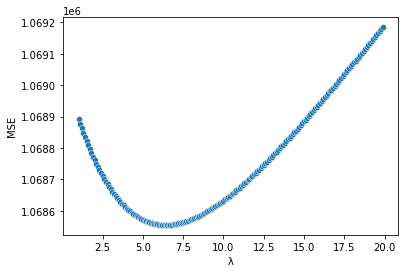

RMSE CV: 1033.7092919308889
@Lambda: 6.400000000000005


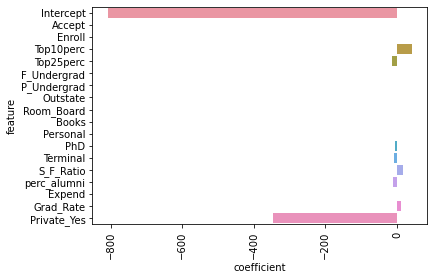

,feature,coefficient
0,Intercept,-808.261769
1,Accept,1.240118
2,Enroll,0.293775
3,Top10perc,42.238162
4,Top25perc,-14.374250
5,F_Undergrad,-0.012896
6,P_Undergrad,0.057522
7,Outstate,-0.055904
8,Room_Board,0.135773
9,Books,-0.191998


In [14]:
# Perform 10 fold cross validation to find optimal λ

def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
        m = model.fit(X_train, y_train)
        
        # Measure MSE
        y_hat = m.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

def optimise(X, y, cv, lambdas):
    MSEs = [] 
    for l in lambdas:
        MSEs += [np.mean(cv(X, y, λ=l, k=10))]
    
    sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
    plt.show();
    
    lamb = min(zip(MSEs, lambdas))
    print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))

    # What coefficients does ridge regression choose for the optimal lambda value?
    λ = min(zip(MSEs, lambdas))[1]
    model = model = linear_model.Ridge(alpha=λ, fit_intercept=True, normalize=False, solver='cholesky')
    m = model.fit(X, y)
    
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [m.intercept_]})
    ridge_df  = intercept.append(pd.DataFrame({'feature': X.columns, 'coefficient': m.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=ridge_df)
    plt.xticks(rotation=90)
    plt.show();
    
    display(ridge_df)
    return lamb[1]

     
opt_lamb = optimise(X_train, y_train, ridge_cv, np.arange(1, 20, .1))

In [16]:
# Use optimal lambda value optained in previous step, then test model on test set.
model = model = linear_model.Ridge(alpha=opt_lamb, fit_intercept=True, normalize=False, solver='cholesky')
# Fit on full training setl
model.fit(X_train, y_train)
# Get test rmse
y_hat = model.predict(X_test)
print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))

RMSE Test: 1230.2863913806939


So ridge regression performs worse than linear regression with all features (1230 vs 1229)
That's not too bad, in all honesty.

**d)** \
Lasso\
I am expecting similar values for some reason. Let's see.

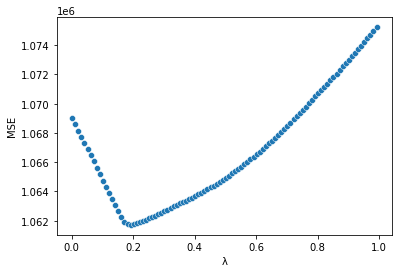

RMSE CV: 1030.3953270677769
@Lambda: 0.19099999999999998


In [17]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                                   normalize=True, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

lambdas = np.arange(.001, 1, .01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

lamb = min(zip(MSEs, lambdas))
print('RMSE CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))

In [18]:
def lasso_test(λ):
    # Fit model on full training set with optimal lambda
    model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                               normalize=True, positive=False, precompute=False, random_state=None,
                               selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
    
    # Get test rmse
    y_hat = model.predict(X_test)
    print('RMSE Test: {}'.format(np.sqrt(mse(y_hat, y_test))))
    
    # # What coefficients does the lasso choose for the optimal lambda value?
    intercept = pd.DataFrame({'feature': 'Intercept', 'coefficient': [model.intercept_]})
    lasso_df  = intercept.append(pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_}), ignore_index=True)
    
    ax = sns.barplot(x='coefficient', y='feature', data=lasso_df);
    plt.xticks(rotation=90)
    plt.show();
    
    display(lasso_df)

interact(lasso_test, λ=widgets.FloatSlider(min=lamb[1]/100, max=lamb[1]*10, step=0.01, value=lamb[1]));

interactive(children=(FloatSlider(value=0.19099999999999998, description='λ', max=1.9099999999999997, min=0.00…

Oh. Okay, I was slightly off but Lasso wins with a slight margin at 1228.

**e)**\
PCR model with M chosen by CV. 

In [19]:
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load data
    X = college_df[train].drop(response, axis=1)
    y = college_df[train][response]
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    #ax.axes.set_ylim(100000, 140000)

    # Make Test predictions
    # ---------------------------------------
    
    # Get optimal number of compoenents from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    
    # Get all principle components across train and test values for X
    X_reduced = pca.fit_transform(scale(college_df.drop(response, axis=1)))
    
    # Fit model on TRAINING subset of PCs
    model = LinearRegression()
    model.fit(X_reduced[train][:, 0:m+1], y_train)
    # Predict using TEST subset of PCs
    y_hat = model.predict(X_reduced[~train][:, 0:m+1])
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat, y_test))
    display(best_df)
    
    print(model.score(X_reduced[~train][:, 0:m+1], y_test))
    

interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));


interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

**f)**\
PLS model with M chosen by CV

In [20]:
# Breif Comment
from sklearn.cross_decomposition import PLSRegression

def pls_cv(seed, cv_folds):
    """Perform Partial Least Squares Regression evaluated with
    k-fold cross validation"""

    # Select components with cross-validation
    # ---------------------------------------
    # Load test data
    X_train = np.array(college_df[train].drop(response, axis=1))
    y_train = np.array(college_df[train][response])   
    X_test  = np.array(college_df[~train].drop(response, axis=1))
    y_test  = np.array(college_df[~train][response])
    
    # Get cv MSE for cumulative components
    M = X_train.shape[1]
    MSEs = []
    for m in range(M):
        cv      = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        results = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10000), 
                                  X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        MSEs   += [np.mean(np.abs(results))]
        
    df = pd.DataFrame({'principal components count': np.arange(1, M+1), 'RMSE_CV': np.sqrt(MSEs)})
    ax = sns.lineplot(x='principal components count', y='RMSE_CV', data=df)
    plt.show();
    
    # Make Test predictions
    # ---------------------------------------
    # Get optimal number of components from cv results
    m = df[df['RMSE_CV'] == df['RMSE_CV'].min()]['principal components count'].iloc[0]
    print(m)

    # Fit model on TRAINING subset of PCs
    model = PLSRegression(n_components=m, scale=True, max_iter=10000).fit(X_train, y_train)
    # Predict using TEST subset of PCs
    X_test_r, y_test_r = model.transform(X_test, y_test)
    y_hat = model.predict(X_test)
    
    # Show results for optimal number of components
    best_df = df[df['RMSE_CV'] == df['RMSE_CV'].min()]
    best_df['RSME_Test'] = np.sqrt(mse(y_hat.T[0], y_test))
    display(best_df)

    
interact(pls_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

**THE RESULTS ARE IN**\
Model	RSME test\
Lasso	1228.58\
OLS	1229.13\
PCR	1229.13\
Ridge	1230.29\
PLS	1230.36

**g)**\
Comment on teh results. Well, they are quite close to each other so I wouldn't say that any one of these methods outperforms the rest
when it comes to this specific dataset. The mean number of applications received is ~3000. So a margin of error of around 1200 is bad no matter which way you see it. So in conclusion, for this dataset, all methods perform kind of the same and all of them are quite bad. Why though? The only explanation that I can think of is that the relationship is non linear. Maybe non linear methods would work better for this.
